In [80]:
# Styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../src/rise.css", "r").read()
    return HTML(styles)
css_styling()

<h1><center>Space missions data understanding, visualization and analysis</center></h1>

<center><img src="https://specials-images.forbesimg.com/imageserve/5ec807d92ce8db0007986fb2/960x0.jpg?fit=scale"></center>

In [81]:
import numpy as np
import pandas as pd

import plotly.express as px

# !pip install iso3166
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from collections import OrderedDict
import warnings
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## 1. General dataset overview

In [82]:
df = pd.read_csv('../input/Space_Corrected.csv')

df.columns = [
    'Unnamed: 0', 
    'Unnamed: 0.1', 
    'Company Name', 
    'Location', 
    'Datum', 
    'Detail', 
    'Status Rocket', 
    'Rocket', 
    'Status Mission'
]

df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df.head()

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success


Let's see percent of NaNs for every column.

In [83]:
missed = pd.DataFrame()
missed['column'] = df.columns
percent = list()

for col in df.columns:
    percent.append(round(100* df[col].isnull().sum() / len(df), 2))

missed['percent'] = percent
missed = missed.sort_values('percent')
missed = missed[missed['percent']>0]

fig = px.bar(
    missed, 
    x='percent', 
    y="column", 
    orientation='h', 
    title='Missed values percent for every column (percent > 0)', 
    width=600,
    height=200 
)

fig.show()

From this short chart we can see that we have only 1 column that contains missed values. It is `Rocket` column with about 80% of missed values.

Now let's see how many launches made every company presented in this dataset.
What about rocket's status?
Now we will check status distribution for all missions.

In [84]:
ds = df['Company Name'].value_counts().reset_index()

ds.columns = [
    'company', 
    'number of starts'
]

ds = ds.sort_values(['number of starts'])

fig = px.bar(
    ds, 
    x='number of starts', 
    y="company", 
    orientation='h', 
    title='Number of launches by every company', 
    width=800,
    height=1000 
)

fig.show()

## 2. Geo analysis

First we need to extract `country` feature and change some country names.

In [85]:
countries_dict = {
    'Russia' : 'Russian Federation',
    'New Mexico' : 'USA',
    "Yellow Sea": 'China',
    "Shahrud Missile Test Site": "Iran",
    "Pacific Missile Range Facility": 'USA',
    "Barents Sea": 'Russian Federation',
    "Gran Canaria": 'USA'
}

df['country'] = df['Location'].str.split(', ').str[-1].replace(countries_dict)

Let's see sunburst chart for countries.

In [86]:
sun = df.groupby(['country', 'Company Name', 'Status Mission'])['Datum'].count().reset_index()

sun.columns = [
    'country', 
    'company', 
    'status', 
    'count'
]

fig = px.sunburst(
    sun, 
    path=[
        'country', 
        'company', 
        'status'
    ], 
    values='count', 
    title='Sunburst chart for all countries',
    width=600,
    height=600
)

fig.show()

Now let's convert country name to Alpha3 format using iso3166 package.

In [89]:
from iso3166 import countries

country_dict = dict()
for c in countries:
    country_dict[c.name] = c.alpha3
    
df['alpha3'] = df['country']
df = df.replace(
    {
        "alpha3": country_dict
    }
)
df.loc[df['country'] == "North Korea", 'alpha3'] = "PRK"
df.loc[df['country'] == "South Korea", 'alpha3'] = "KOR"

df

,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission,country,alpha3
0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.0,Success,USA,USA
1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success,China,CHN
2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success,USA,USA
3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.0,Success,Kazakhstan,KAZ
4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.0,Success,USA,USA
...,...,...,...,...,...,...,...,...,...
4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure,USA,USA
4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,NaN,Success,USA,USA
4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,NaN,Failure,USA,USA
4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,NaN,Success,Kazakhstan,KAZ


In [90]:
# This function takes in the dataframe and create a map graph for the specified target column.
def plot_map(dataframe, target_column, title, width=800, height=600):
    mapdf = dataframe.groupby(['country', 'alpha3'])[target_column].count().reset_index()
    fig = px.choropleth(
        mapdf, 
        locations="alpha3", 
        hover_name="country", 
        color=target_column, 
        projection="natural earth", 
        width=width, 
        height=height, 
        title=title
    )
    fig.show()

How many launches every country has?

In [91]:
plot_map(
    dataframe=df, 
    target_column='Status Mission', 
    title='Number of starts per country'
)

How many Failures every country has?

In [92]:
fail_df = df[df['Status Mission'] == 'Failure']
plot_map(fail_df, 'Status Mission', 'Number of Fails per country')

## 3. Other interesting questions

Let's create traditional features based on Date.

In [93]:
df['date'] = pd.to_datetime(df['Datum'])
df['year'] = df['date'].apply(lambda datetime: datetime.year)
df['month'] = df['date'].apply(lambda datetime: datetime.month)
df['weekday'] = df['date'].apply(lambda datetime: datetime.weekday())

How many launches were every year?

In [94]:
ds = df['year'].value_counts().reset_index()

ds.columns = [
    'year', 
    'count'
]
# Bar chart for number of missions by year 
fig = px.bar(
    ds, 
    x='year', 
    y="count", 
    orientation='v', 
    title='Missions number by year', 
    width=800
)

fig.show()

What is months distribution?

In [95]:
# Prepare the dataframe and plot the number of missions by `month`. Refer example above for `year`. 


What is weekday distribution?

In [96]:
# Prepare the dataframe and plot the number of missions by `weekday`. Refer example above for `year`. 


Which companies are most experienced (years)?

In [98]:
ds = df.groupby(['Company Name'])['year'].nunique().reset_index()

ds.columns = [
    'company', 
    'count'
]

fig = px.bar(
    ds, 
    x="company", 
    y="count", 
    title='Most experienced companies (years of launches)'
)

fig.show()

Number of starts for 2020.

In [99]:
data = df.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

data = data[data['year']==2020]

In [100]:
fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Number of starts for 2020', 
    width=800
)

fig.show()

In [101]:
data = df[df['Status Mission']=='Failure']
data = data.groupby(['Company Name', 'year'])['Status Mission'].count().reset_index()

data.columns = [
    'company', 
    'year', 
    'starts'
]

data = data[data['year']==2020]

fig = px.bar(
    data, 
    x="company", 
    y="starts", 
    title='Failures in 2020', 
    width=600
)

fig.show()

## 4. Predict dynamics for CASC

As we can see CASC company has the higher number of launches in 2020. So lets try to predict dynamics for next 5 years for this company using univariate model.

In [102]:
casc_df = df[df['Company Name'] == 'CASC']
casc_df = casc_df.groupby(['year'])['Company Name'].count().reset_index()
casc_df = casc_df[casc_df['year'] < 2020]

casc_df.columns = [
    'year', 
    'launches'
]

fig = px.line(
    casc_df, 
    x="year", 
    y="launches", 
    title='Launches per year for CASC'
)

fig.show()

# 5. Exponential Time Smoothing

Using the `launches` column from the `casc_df` above, fit an exponential smoothing model. 

Please import the `ExponentialSmoothing, SimpleExpSmoothing` from statsmodel.

In [103]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

### Simple Exponential Smoothing

Refer `SimpleExponentialSmoothing` documentation <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html">here.</a> 

Create 3 new columns, each representing the different alpha values for SES for alpha, `a = 0.3, 0.7 and 0.9`. Complete the code below. Use the `casc_df`, target column is called <u>launches</u>

In [ ]:
# Use SES on launches column
alpha = [0.3, 0.7, 0.9]
casc_df['ses0.3'] =
casc_df['ses0.7'] =
casc_df['ses0.9'] =

### Double Exponential Smoothing
Holt-Winters Additive Trend
Refer Holt-Winter's Exponential Smoothing Example <a href="https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing">here</a>

Fit a model using `Exponential Smoothing, Trend = 'add'`. Create a new column called `des_add` for launches.

In [ ]:
## Complete the code below.
casc_df['des_add'] = 

In [ ]:
casc_df.head()

### Double Exponential Smoothing
Holt-Winter's Multiplicative Trend 

What happens when we use the the <u>multiplicative trend</u> in Double Exponential Smoothing?

In [ ]:
casc_df['des_mul'] = 

In [ ]:
# Visualise the output
casc_df[['launches','ses0.3', 'des_add','des_mul']].iloc[:24].plot(title='Holt Winters Double Exponential Smoothing Last (Additive vs Multiplicative)').autoscale(axis='x',tight=True)

# 6. Univariate Forecasting 

Based on the plots, let's try to build a model for the CASC launches using the <u>DES_add</u> model.

In [ ]:
m1 = ExponentialSmoothing(casc_df['launches'], trend = 'mul').fit()
ax = m1.fittedvalues.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
m1.forecast(3).rename('Holt-Winter Multiplicative').plot(ax = ax, style = '--', color = 'red', legend = True, marker = 'o')

# 7. Time series decomposition

In [ ]:
## Determining the number of Launch attempts by year-month. 
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['month_year'] = pd.to_datetime(df['month_year']).dt.to_period('M')
ds = df.groupby(['month_year'])['alpha3'].count().reset_index()
ds.columns = ['month_year', 'count']
ds['month_year'] = ds['month_year'].astype(str)

fig = px.line(
    ds, 
    x='month_year', 
    y='count', 
    orientation='v', 
    title='Launches by months' 
)

fig.show()

December 1971 is most active month for Launch attempts.

Let's do decomposition of time series of number of launches for every month.

In [ ]:
dates = ['1957-10-01', '2020-08-02']
start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates]
dd = pd.DataFrame(
    list(
        OrderedDict(((start + timedelta(_)).strftime(r"%Y-%m"), None) for _ in range((end - start).days)).keys()
    ), 
    columns=['date']
)
dd['date'] = pd.to_datetime(dd['date'])
ds['month_year'] = pd.to_datetime(ds['month_year'])
res = pd.merge(ds, dd, how='outer', left_on='month_year', right_on='date')
res = res.sort_values('date')[['date', 'count']]
res = res.fillna(0).set_index('date')

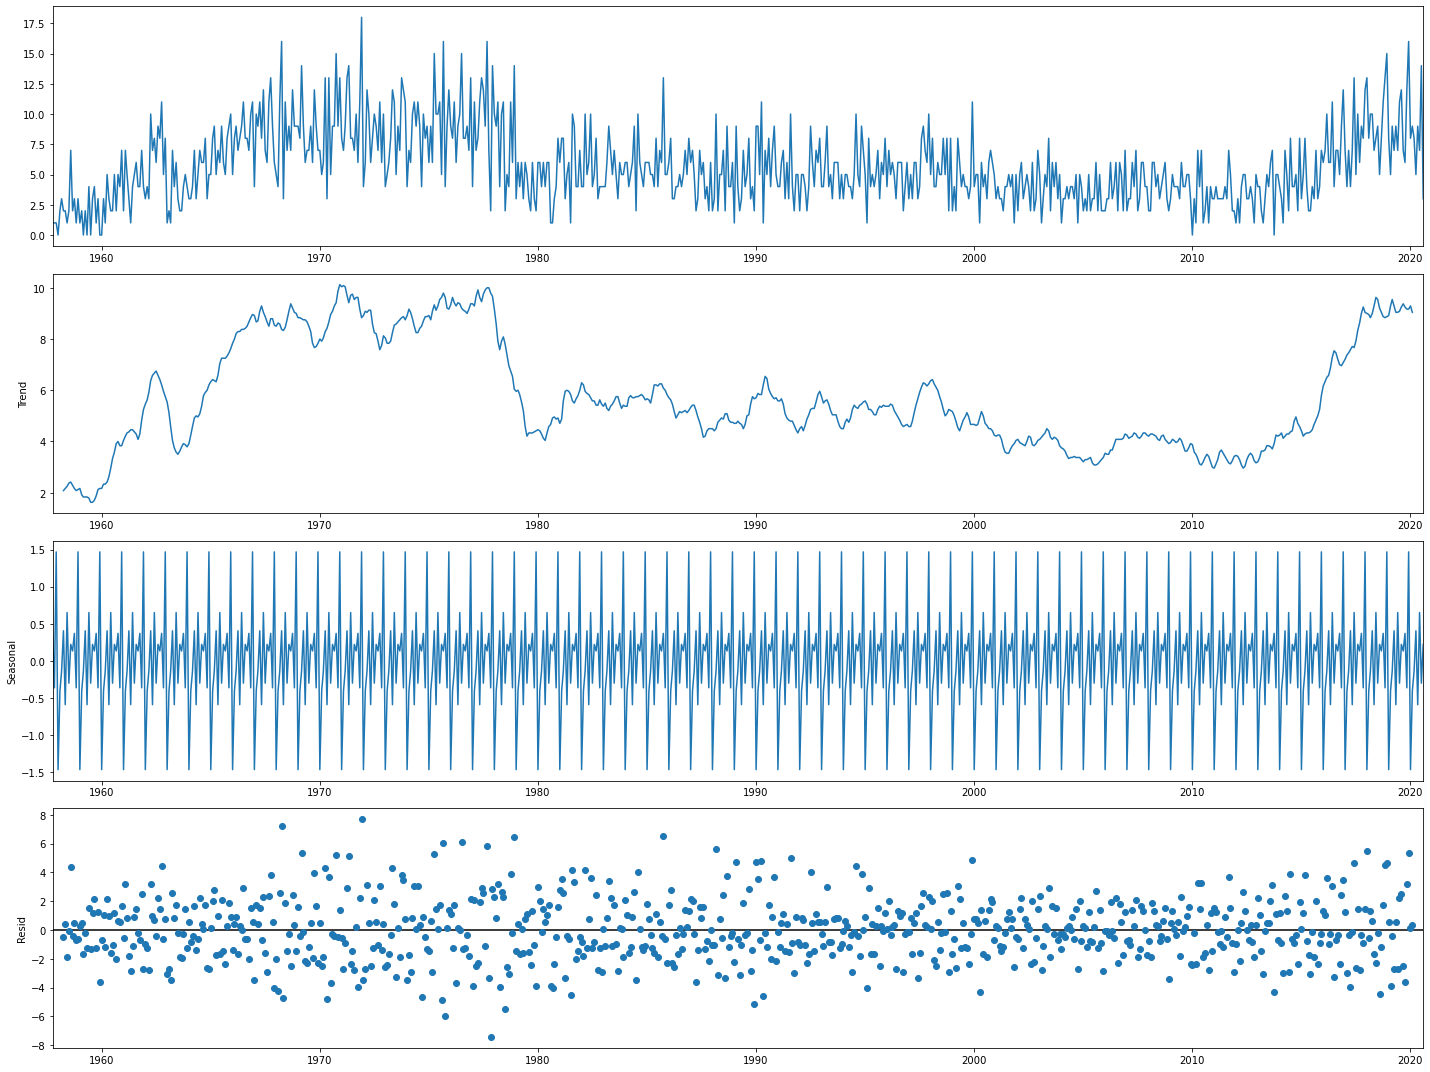

In [104]:
# Use seasonal_decompose on res, (model = 'additive', period = 12). Visualise the result.
result = 


Let's drop noise from time series

In [105]:
ts = (result.trend + result.seasonal).reset_index()
ts.columns = ['date', 'count']
ts['origin'] = 'cleaned'
dres = res.reset_index()
dres['origin'] = 'original'
data = pd.concat([dres, ts])

In [106]:
fig = px.line(
    data, 
    x='date', 
    y='count', 
    color='origin', 
    orientation='v', 
    title='Original and cleaned time series', 
    width=700
)

fig.show()

### Simple ARIMA modeling

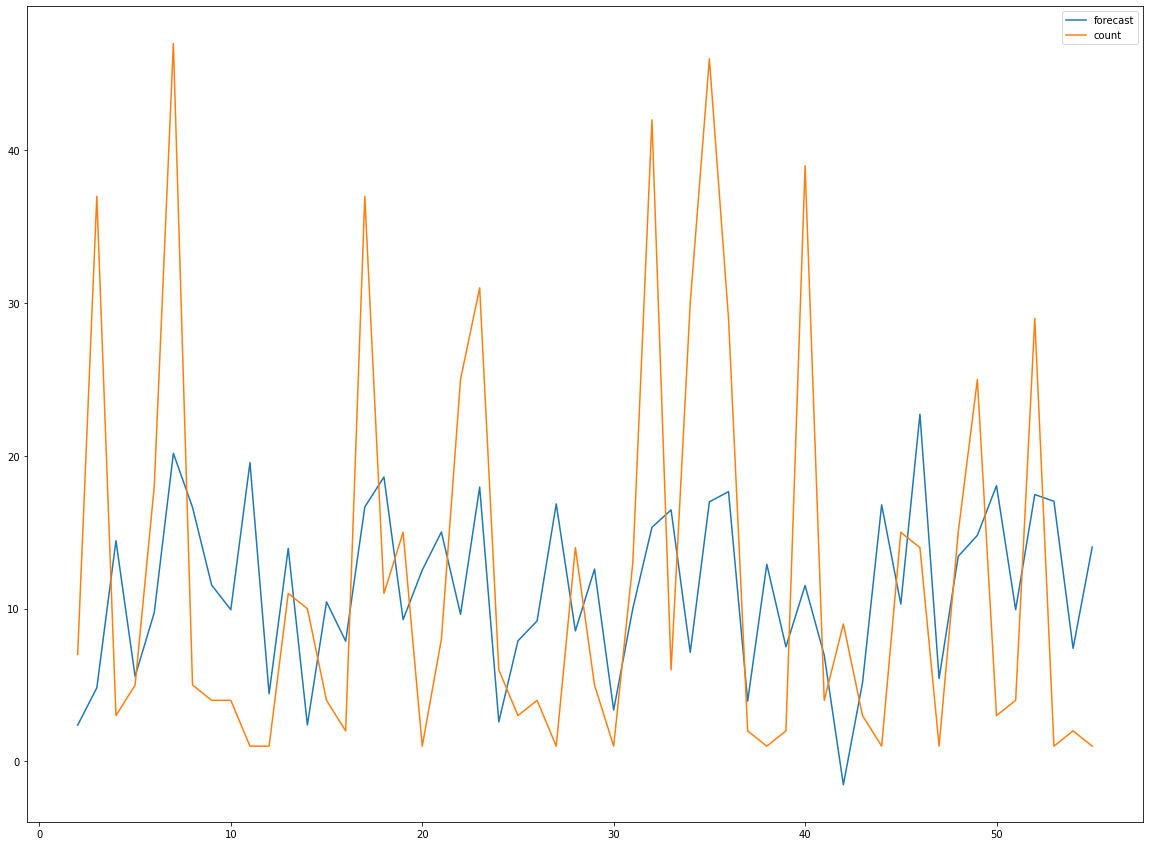

In [107]:
model = ARIMA(ds['count'], order=(10,1,2))
model_fit = model.fit()

model_fit.plot_predict(dynamic=False)

plt.show()

In [108]:
preds, _, _ = model_fit.forecast(16)
preds = preds.tolist()
preds = [int(item) for item in preds]
months = [
    '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', 
    '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', 
    '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', 
    '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'
]

new_df = pd.DataFrame()
new_df['month_year'] = months
new_df['count'] = preds
data = pd.concat([ds, new_df])

fig = px.line(
    data, 
    x="month_year", 
    y="count", 
    title='Launches per month prediction'
)

fig.show()

## END
For full sample notebook, click <a href="https://www.kaggle.com/isaienkov/space-missions-eda-time-series-anaysis/notebook">here</a>